In [1]:
################################################################################
# %% CONNECT TO DRIVE
################################################################################

from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
################################################################################
# %% IMPORT PACKAGES
################################################################################

import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import sys
from time import time
import matplotlib.pyplot as mp
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [0]:
################################################################################
# %% LOAD DATA AND SPLIT  <-- TO BE MOVED INTO GENERATOR!
################################################################################

X = np.load('drive/My Drive/Data/image-0.npy')#[0:4096]
y = np.load('drive/My Drive/Data/label-0.npy')#[0:4096]
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [0]:
################################################################################
# %% NORMALIZE INPUT DATA
################################################################################

X_train = X_train/255.0
X_test = X_test/255.0

In [0]:
"""
################################################################################
# %% CONNECT TO TPU
################################################################################

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
"""

In [0]:
################################################################################
# %% UNET MODEL
################################################################################

def unet_model():
  
  input_size = (256,256,3)

  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = keras.Model(inputs = inputs, outputs = conv10)
  return model

In [7]:
"""
################################################################################
# %% BUILD AND COMPILE FOR TPU
################################################################################

with strategy.scope():
"""

################################################################################
# %% BUILD UNET MODEL
################################################################################

model = unet_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (Max

In [0]:
################################################################################
# %% INIT CALLBACKS
################################################################################

#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()), update_freq='epoch')
earlystopping = EarlyStopping(monitor='val_loss', patience=3)
modelcheckpoint = ModelCheckpoint('keras_model_checkpoint.h5', monitor='loss',verbose=1, save_best_only=True)

In [9]:
################################################################################
# %% RUN MODEL
################################################################################

history = model.fit(  # <-- TO BE REPLACED WITH fit_generatror
    x=X_train,
    y=y_train,
    epochs=100,
    verbose=1,
    validation_data=(X_test, y_test),
    #use_multiprocessing=True,
    #batch_size=16,
    callbacks=[earlystopping, modelcheckpoint] #tensorboard
)

model.save('keras_model.h5')

Train on 7605 samples, validate on 2535 samples
Epoch 1/100
7584/7605 [============================>.] - ETA: 0s - loss: 0.1967 - acc: 0.9268
Epoch 00001: loss improved from inf to 0.19648, saving model to keras_model_checkpoint.h5
7605/7605 [==============================] - 289s 38ms/sample - loss: 0.1965 - acc: 0.9269 - val_loss: 0.1320 - val_acc: 0.9211
Epoch 2/100
7584/7605 [============================>.] - ETA: 0s - loss: 0.1320 - acc: 0.9300
Epoch 00002: loss improved from 0.19648 to 0.13198, saving model to keras_model_checkpoint.h5
7605/7605 [==============================] - 277s 36ms/sample - loss: 0.1320 - acc: 0.9301 - val_loss: 0.1180 - val_acc: 0.9568
Epoch 3/100
7584/7605 [============================>.] - ETA: 0s - loss: 0.1066 - acc: 0.9639
Epoch 00003: loss improved from 0.13198 to 0.10659, saving model to keras_model_checkpoint.h5
7605/7605 [==============================] - 277s 36ms/sample - loss: 0.1066 - acc: 0.9639 - val_loss: 0.1045 - val_acc: 0.9661
Epoch 4/

KeyboardInterrupt: ignored

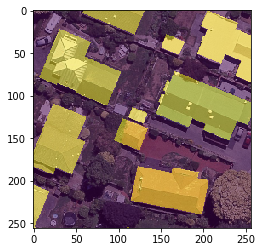

In [13]:
################################################################################
# %% PLOTTING BASE TRUTH
################################################################################

id = 196

mp.imshow(X_test[id,:,:,:])
mp.imshow(y_test[id,:,:,0], alpha=0.5)
mp.show()

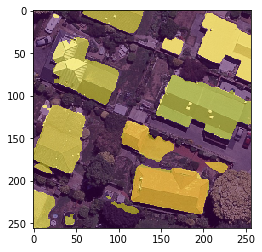

In [14]:
################################################################################
# %% PLOTTING PREDICTION ON TRAINING DATA
################################################################################

X_pred = X_test[id]
X_pred = X_pred[np.newaxis]
y_pred = model.predict(X_pred)

mp.imshow(X_pred[0])
mp.imshow(y_pred[0, :, :, 0]>0.5, alpha=0.5)
mp.show()